In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
from scipy import stats

from thesis.tools.st_utils import file_select
from thesis.tools.cli.utilities import load_gaze_data

/home/anton/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anton/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anton/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anton/miniconda3/envs/tf1/lib/python3.7/site-pack

Deep_eye
conv_unit_1
stride_unit_1


2020-11-10 09:10:26.525 WARNING tensorflow: From /home/anton/git/thesis/Thesis-Code/thesis/deepeye/deepeye.py:74: average_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.average_pooling2d instead.


Last_conv1x1_1
conv_unit_2
stride_unit_2
Last_conv1x1_2
atrous_unit_1


2020-11-10 09:10:27.117 WARNING tensorflow: From /home/anton/git/thesis/Thesis-Code/thesis/deepeye/deepeye.py:109: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.max_pooling2d instead.


conv_unit_3
atrous_unit_2
conv_unit_4
Last_conv1x1_3


2020-11-10 09:10:27.829 WARNING tensorflow: From /home/anton/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-11-10 09:10:27.831 INFO    tensorflow: Restoring parameters from /home/anton/git/thesis/Thesis-Code/thesis/deepeye/models/default.ckpt


Model restored.


In [2]:
from tqdm import tqdm
from numba import njit, prange, jit

from thesis.optim.metrics import *
from thesis.optim import filters

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
gaze_thresholds = ''

In [44]:
file_path = '../../../results/recognition/rc2_gaze_at_1.5x.json'
with open(file_path) as file:
    data = json.load(file)

In [6]:
base_path = '../../../results/recognition/'
file_names = ('rc2_gaze_at_1x.json', 'rc1_gaze_at_2x.json', 'rc1_gaze_at_5x.json')
files = []
for fpath in file_names: 
    with open(os.path.join(base_path, fpath)) as file:
        files.append(json.load(file))

In [7]:
scales = ('1x', '2x', '5x')
files = {s: f for s, f in zip(scales, files)}

In [50]:
config = data['config']
config

{'dataset': '/home/anton/data/eyedata/iris/casia4i.json',
 'filters': {'bilateral_filter': {'sigma_c': 47.58620689655173,
   'sigma_s': 16.06896551724139},
  'gaussian_noise': {'loc': 0.0, 'scale': 26.26262626262626},
  'gaussian_filter': {'sigma': 2.5252525252525255},
  'mean_filter': {'size': 51},
  'median_filter': {'size': 5},
  'non_local_means': {'h': 32.323232323232325},
  'uniform_noise': {'intensity': 93.43434343434345},
  'cauchy_noise': {'scale': 6.4444444444444455},
  'laplacian_noise': {'scale': 22.222222222222225},
  'snow': {'density': 0.17828282828282835},
  'salt_and_pepper': {'intensity': 114.31034482758619,
   'density': 0.5700000000000002}},
 'parameters': {'angles': 6,
  'epsilon': 0.0001,
  'resolution': {'angular': 100, 'radial': 10},
  'rotation': {'num': 7, 'step_size': 3},
  'scales': 4}}

In [6]:
#gaze_sets = ('far_home', 'mor_home', 'anton', 'maja', 'jakob')
gaze_sets = ('anton', 'maja')
#base_path = '/Users/Anton/MEGA/Data/thesis/gaze'
base_path = '/home/anton/data/eyedata/gaze'
gaze_paths = [os.path.join(base_path, g) for g in gaze_sets]
datasets = load_gaze_data(gaze_paths)

48.409
48.409


In [7]:
def test_filter(f_func, args):
    logger = Logger()
    me = GazeAccuracy()

    for dset in datasets:
        for sample in tqdm(dset.test_samples):
            filtered = f_func(sample.image, **args)
            me.log(logger, dset.model, sample, filtered)
    
    return logger

In [51]:
res = []
for k, v in config['filters'].items():
    res.append(test_filter(getattr(filters, k), v))

100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


In [52]:
rd = dict(zip(config['filters'], [r.means() for r in res]))
rd = pd.DataFrame(rd)
rd.loc[1]/rd.loc[0]

bilateral_filter     1.211106
gaussian_noise       1.622173
gaussian_filter      1.091093
mean_filter         22.741451
median_filter        0.885517
non_local_means      1.048596
uniform_noise        1.619822
cauchy_noise         1.744869
laplacian_noise      1.912241
snow                 1.713588
salt_and_pepper      3.936116
dtype: float64

In [20]:
@njit
def metrics(intra, inter, t):
    tp = (intra <= t).sum()
    tn = (inter > t).sum()
    fp = (inter <= t).sum()
    fn = (intra > t).sum()
    return {
        'threshold': t,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'far': fp/(fp+tn),
        'frr': fn/(fn+tp)
    }

@njit
def find_gt(sorted_array, value, start=0):
    i = start
    while i < len(sorted_array):
        if sorted_array[i] >= value:
            break
        i += 1
    return i

@jit
def line(intra, inter):
    res = []
    
    sorted_intra = np.sort(intra)
    sorted_inter = np.sort(inter)
    n_intra = len(intra)
    n_inter = len(inter)
    intra_idx = 0
    inter_idx = 0
    for i in prange(2000):
        x = i/2000
        
        intra_idx = find_gt(sorted_intra, x, intra_idx)
        inter_idx = find_gt(sorted_inter, x, inter_idx)
        
        tp = intra_idx
        tn = n_inter - inter_idx
        fp = inter_idx
        fn = n_intra - intra_idx
        
        m = {
            'threshold': x,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'far': fp/(fp+tn),
            'frr': fn/(fn+tp),
        }
        res.append(m)
    return res

In [45]:
res = []
for spec in tqdm(data['results'].keys()):
    intra = np.array(data['results'][spec]['intra_distance'])
    inter = np.array(data['results'][spec]['inter_distance'])
    ls = line(intra, inter)
    ls = list(map(dict, ls))
    for l in ls:
        l['name'] = spec
        #l['scale'] = 
    res.extend(ls)

100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


In [46]:
df = pd.DataFrame.from_records(res)
df['precision'] = df['tp']/(df['tp']+df['fp'])
df['recall'] = df['tp']/(df['tp']+df['fn'])
df['f1'] = (df['precision']*df['recall'])/(df['precision'] + df['recall'])
df['accuracy'] = (df['tp']+df['tn'])/(df['tp']+df['tn']+df['fp']+df['fn'])

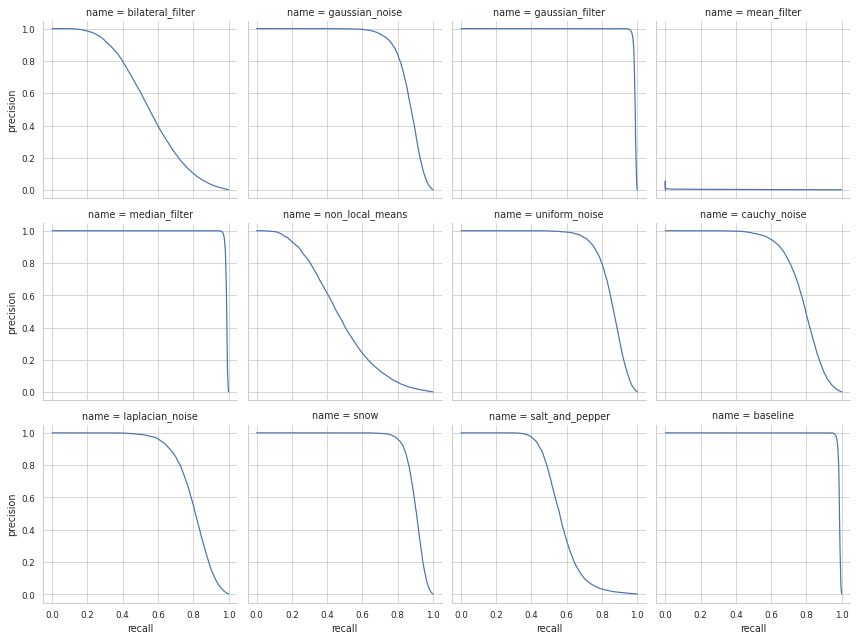

In [47]:
gr = sns.FacetGrid(df, col='name', col_wrap=4)

gr.map(sns.lineplot, 'recall', 'precision')

<AxesSubplot:xlabel='recall', ylabel='precision'>

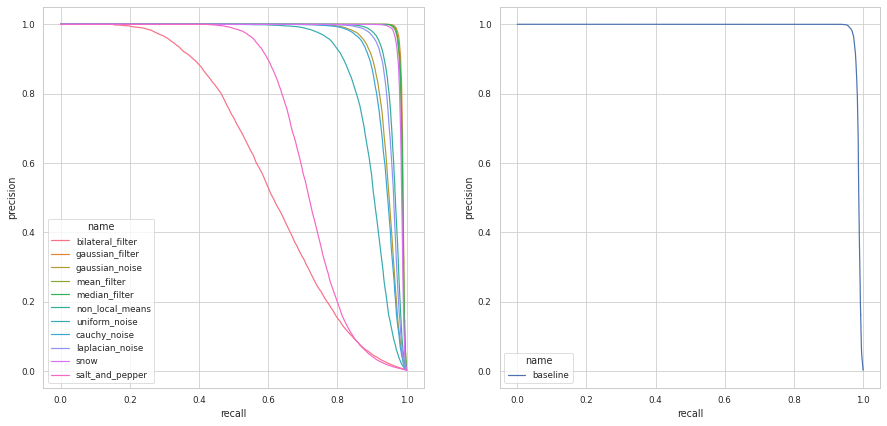

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

others = df[df['name'] != 'baseline']
bl = df[df['name'] == 'baseline']
sns.F
sns.lineplot(x='recall', y='precision', hue='name', data=others, ax=ax[0])
sns.lineplot(x='recall', y='precision', hue='name', data=bl, ax=ax[1])
#ax.set_xscale('log')
#ax.set_yscale('log')

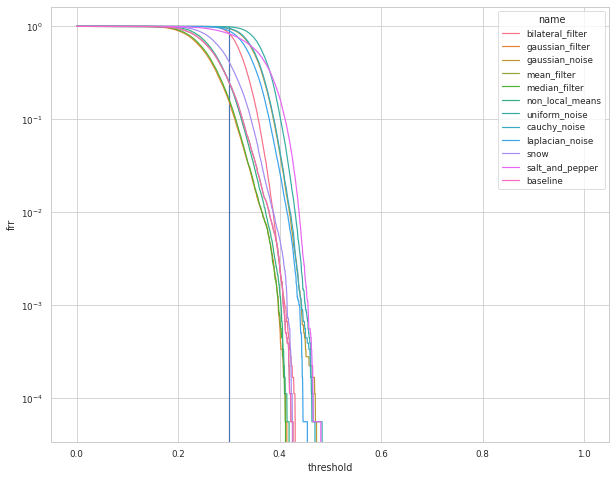

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='threshold', y='frr', hue='name', data=df, ax=ax)
ax.set_yscale('log')
ax.vlines(0.3, 0, 1)

In [25]:
pv = df.pivot(columns='name', index='threshold')

In [29]:
ts = np.round(np.arange(0.3, 0.4, 0.01), decimals=2)
pv.loc[ts]['precision']

name,baseline,bilateral_filter,cauchy_noise,gaussian_filter,gaussian_noise,laplacian_noise,mean_filter,median_filter,non_local_means,salt_and_pepper,snow,uniform_noise
threshold,,,,,,,,,,,,
0.30,1.000000,0.997891,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999925,1.000000,1.000000,1.000000
0.31,1.000000,0.973083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999317,1.000000,1.000000,1.000000
0.32,1.000000,0.834846,1.000000,1.000000,1.000000,1.000000,1.000000,0.999939,0.992349,1.000000,1.000000,1.000000
0.33,1.000000,0.539312,1.000000,0.999296,1.000000,1.000000,1.000000,0.998942,0.949172,1.000000,1.000000,1.000000
0.34,0.999525,0.258556,1.000000,0.988928,1.000000,1.000000,0.999525,0.984696,0.784701,1.000000,1.000000,1.000000
0.35,0.989636,0.102885,1.000000,0.926220,1.000000,1.000000,0.989636,0.902184,0.467950,0.999211,0.998853,1.000000
0.36,0.928275,0.040561,1.000000,0.699097,1.000000,0.999924,0.928275,0.640260,0.196177,0.989087,0.986290,1.000000
0.37,0.683247,0.017993,0.998551,0.339868,0.998800,0.996651,0.683247,0.290855,0.073055,0.930796,0.884809,0.999470
0.38,0.308541,0.009266,0.981064,0.119583,0.982511,0.963554,0.308541,0.100458,0.028946,0.708843,0.535383,0.994561


In [27]:
sns.set_theme('paper')
sns.set_style('whitegrid')

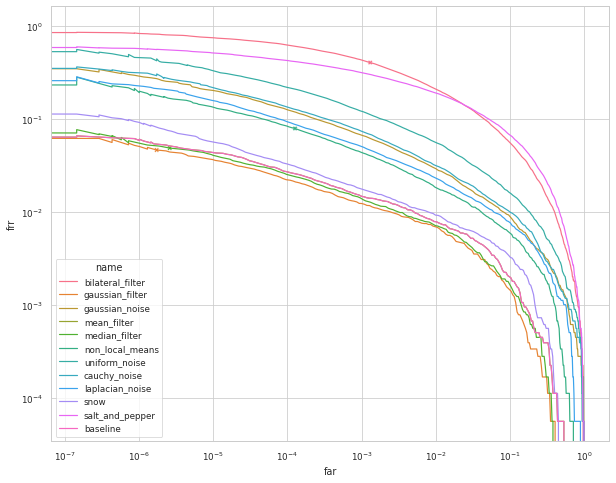

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='far', y='frr', hue='name', data=df, ax=ax, estimator=None)
sns.scatterplot(x='far', y='frr', hue='name', data=df[df['threshold'] == 0.33], ax=ax, marker='X', legend=False)

ax.set_xscale('log')
ax.set_yscale('log')